<a href="https://colab.research.google.com/github/AbhinavRadhakrishnan/Machine-Learning-Projects/blob/main/Rice_Leaf_Diseases.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Problem Statement**

Rice is an important food crop, and its leaves are often affected by diseases like Leaf Smut, Brown Spot, and Bacterial Leaf Blight. If these diseases are not detected early, they can reduce crop quality and yield. Manually checking each plant is slow and can lead to mistakes.

This project aims to use a small dataset of 120 images of rice leaves to build a machine learning model that can automatically identify which disease is present in an image.
The work includes:

Analyzing the dataset to understand its structure and patterns.

Creating a model that can classify the three major rice leaf diseases.

Using methods like data augmentation and transfer learning to improve accuracy since the dataset is small.

The goal is to make rice disease detection faster, easier, and more accurate, helping farmers take timely action to protect their crops.

In [1]:
# PRCP-1001 Rice Leaf Disease Detection

In [2]:
!pip install split-folder -q
#automatically split images into train/val/test.

In [3]:
from google.colab import drive
drive.mount('/content/drive')
#Connects drive with colab

Mounted at /content/drive


In [4]:
#importing dependencies
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import shutil


In [5]:
!pip install split-folders


In [6]:
import splitfolders

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, applications
from sklearn.metrics import confusion_matrix, classification_report


importing Dataset which is in Zip format

In [7]:
drive_path = "/content/drive/MyDrive/Datasets/PRCP-1001-RiceLeaf"


In [8]:
print("folder exists :", os.path.exists(drive_path)) #to check wheather the path is there or not


folder exists : True


copying dataset folder from drive to colab for faster access

In [9]:
local_dataset_dir = "/content/drive/MyDrive/Datasets/PRCP-1001-RiceLeaf"
#if the folder is not present in colab it will copy from drive and make local_dataset_dir
if not os.path.exists(local_dataset_dir):
    shutil.copytree(drive_path, local_dataset_dir)

In [10]:
# Set base_dir to the local copied folder
base_dir = local_dataset_dir
print("Base dir:", base_dir)
print("Classes:", os.listdir(base_dir))

Base dir: /content/drive/MyDrive/Datasets/PRCP-1001-RiceLeaf
Classes: ['Bacterial leaf blight', 'Brown spot', 'Leaf smut']


spliting dataset into Train , Test and Validation


In [11]:
output_dir = "/content/rice_splits"

splitfolders.ratio(
    base_dir,
    output=output_dir,
    seed=42, #every time you run the code, you get the same result.
    ratio=(0.7, 0.15, 0.15)
)


Copying files: 119 files [01:03,  1.88 files/s]


In [12]:

for split in ["train", "val", "test"]:
    data_folder = os.path.join(output_dir, split, "Data")
    if os.path.exists(data_folder):
        print("Removing extra folder:", data_folder)
        shutil.rmtree(data_folder)

In [13]:
print("Split folders:")
!ls /content/rice_splits


Split folders:
test  train  val


In [14]:
print(output_dir)

/content/rice_splits


Exploratory Data Analysis

In [15]:

for cls in os.listdir(base_dir):
    cls_path = os.path.join(base_dir, cls)
    files = glob.glob(os.path.join(cls_path, "*"))
    images = [f for f in files if f.lower().endswith((".jpg", ".jpeg"))]
    print(f"{cls:} -> {len(images)} images")


Bacterial leaf blight -> 40 images
Brown spot -> 40 images
Leaf smut -> 39 images


show sample images


In [16]:
def show_samples(cls_name, n=4):
    #Build the path to the class folder
    cls_path = os.path.join(base_dir, cls_name)

    #Get all files in that folder
    files = glob.glob(os.path.join(cls_path, "*"))

    #Keep only images with .jpg / .jpeg (case-insensitive)
    img_paths_all = [f for f in files if f.lower().endswith((".jpg", ".jpeg"))]

    #Pick n random images (or fewer if not enough images)
    if len(img_paths_all) == 0:
        print(f"No images found in class: {cls_name}")
        return

    k = min(n, len(img_paths_all))  # avoid error if less images than n
    img_paths = random.sample(img_paths_all, k)

    #Plot the images
    plt.figure(figsize=(10, 3))
    for i, p in enumerate(img_paths):
        img = Image.open(p)
        plt.subplot(1, k, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(cls_name[:15])
    plt.show()


Sample images per class 

Bacterial leaf blight:


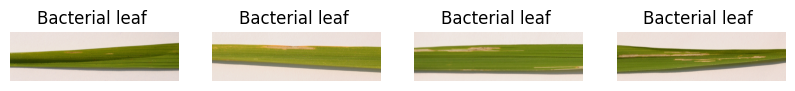

Brown spot:


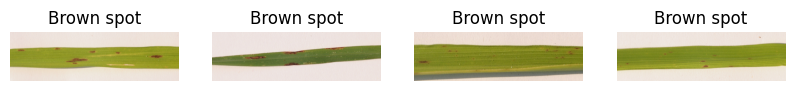

Leaf smut:


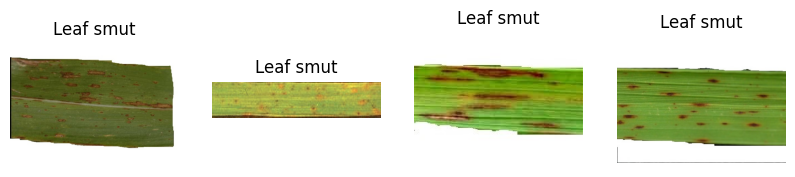

In [17]:
print("Sample images per class \n")
for cls in os.listdir(base_dir):
    print(f"{cls}:")
    show_samples(cls)


Data Generators

In [18]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 8

train_dir = os.path.join(output_dir, "train")
val_dir   = os.path.join(output_dir, "val")
test_dir  = os.path.join(output_dir, "test")


No augmentation

In [19]:
train_datagen_no_aug = ImageDataGenerator(
    rescale=1./255
)
#nueral networks works best with smaller pixel that is between 0 - 1 so all the images are rescaled into that particular range

with Augmentation

In [20]:
train_datagen_aug = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)


for validation

In [21]:
val_test_datagen = ImageDataGenerator(
    rescale=1./255
)
#no augment
train_gen_no_aug = train_datagen_no_aug.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)
#augment
train_gen_aug = train_datagen_aug.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

Found 83 images belonging to 3 classes.
Found 83 images belonging to 3 classes.


In [22]:
val_gen = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)


Found 17 images belonging to 3 classes.


In [23]:
test_gen = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)


Found 19 images belonging to 3 classes.


In [24]:
print("Train subfolders:", os.listdir(train_dir))
print("Val subfolders  :", os.listdir(val_dir))
print("Test subfolders :", os.listdir(test_dir))


Train subfolders: ['Brown spot', 'Bacterial leaf blight', 'Leaf smut']
Val subfolders  : ['Brown spot', 'Bacterial leaf blight', 'Leaf smut']
Test subfolders : ['Brown spot', 'Bacterial leaf blight', 'Leaf smut']


Defining the model


creating CNN


In [25]:
num_classes = 3
#creating CNN
def create_baseline_cnn():
    model = models.Sequential([
        layers.Input(shape=(*IMG_SIZE, 3)),

        layers.Conv2D(32, (3,3), activation="relu"),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(64, (3,3), activation="relu"),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(128, (3,3), activation="relu"),
        layers.MaxPooling2D((2,2)),

        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(128, activation="relu"),
        layers.Dense(num_classes, activation="softmax")
    ])



    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model


MobileNetV2 model

In [26]:
def create_mobilenet_model():
    base_model = applications.MobileNetV2(
        weights="imagenet",
        include_top=False,
        input_shape=(*IMG_SIZE, 3)
    )
    base_model.trainable = False  # freeze base initially


    inputs = layers.Input(shape=(*IMG_SIZE, 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = models.Model(inputs, outputs)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model


TRAINING UTILS


In [27]:
early_stop = tf.keras.callbacks.EarlyStopping(
    patience=5,
    restore_best_weights=True,
    monitor="val_accuracy"
)


In [28]:
def plot_history(h, title_prefix=""):
    acc = h.history['accuracy']
    val_acc = h.history['val_accuracy']
    loss = h.history['loss']
    val_loss = h.history['val_loss']
    epochs = range(1, len(acc) + 1)


    plt.figure(figsize=(12,4))

    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(epochs, acc, label='Train Acc')
    plt.plot(epochs, val_acc, label='Val Acc')
    plt.title(title_prefix + "Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    # Loss
    plt.subplot(1,2,2)
    plt.plot(epochs, loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Val Loss')
    plt.title(title_prefix + "Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()


Model 1 - Cnn(With augmentation)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.3481 - loss: 1.6759 - val_accuracy: 0.3529 - val_loss: 1.0830
Epoch 2/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 965ms/step - accuracy: 0.2553 - loss: 1.0973 - val_accuracy: 0.2941 - val_loss: 1.1162
Epoch 3/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.3198 - loss: 1.0881 - val_accuracy: 0.6471 - val_loss: 0.9792
Epoch 4/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.4503 - loss: 1.0114 - val_accuracy: 0.5882 - val_loss: 0.8415
Epoch 5/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.5085 - loss: 0.8767 - val_accuracy: 0.3529 - val_loss: 1.1513
Epoch 6/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.5136 - loss: 0.7603 - val_accuracy: 0.3529 - val_loss: 1.5303
Epoch 7/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.4666 - loss: 0.9731 - val_accuracy: 0.6471 - val_loss: 0.7799
Epoch 8/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.4483 - loss: 0.8481 - val_accuracy: 0.3529 - val_lo

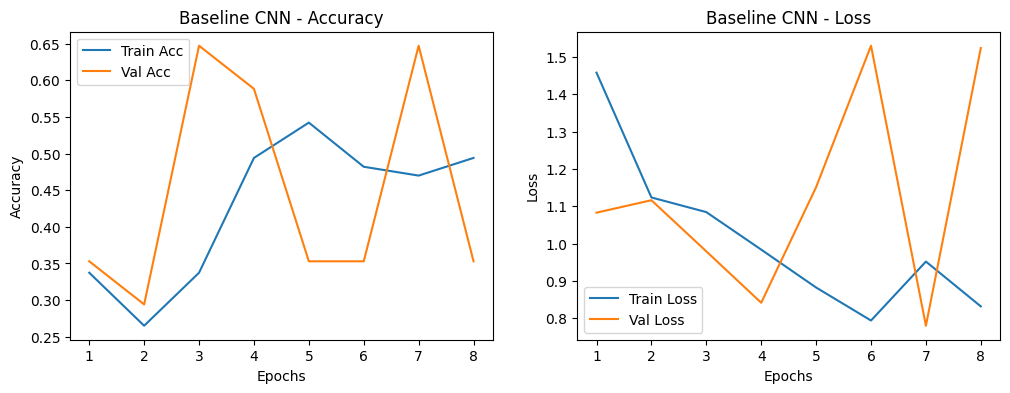

Evaluating Baseline CNN on test set...
Test Accuracy (Baseline CNN): 0.6315789222717285


In [29]:
baseline_cnn = create_baseline_cnn()
history_cnn = baseline_cnn.fit(
    train_gen_aug,
    epochs=25,
    validation_data=val_gen,
    callbacks=[early_stop],
    verbose=1
)
plot_history(history_cnn, "Baseline CNN - ")

print("Evaluating Baseline CNN on test set...")
test_loss_cnn, test_acc_cnn = baseline_cnn.evaluate(test_gen, verbose=0)
print("Test Accuracy (Baseline CNN):", test_acc_cnn)


MODEL 2 – MobileNetV2 with and without augmentation

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 636ms/step - accuracy: 0.4648 - loss: 1.1540 - val_accuracy: 0.5882 - val_loss: 1.0954
Epoch 2/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 345ms/step - accuracy: 0.5823 - loss: 0.8634 - val_accuracy: 0.7059 - val_loss: 0.8741
Epoch 3/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 449ms/step - accuracy: 0.6486 - loss: 0.7609 - val_accuracy: 0.8824 - val_loss: 0.7340
Epoch 4/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 399ms/step - accuracy: 0.6588 - loss: 0.6541 - val_accuracy: 0.7647 - val_loss: 0.7629
Epoch 5/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 335ms/step - accuracy: 0.7807 - loss: 0.5394 - val_accuracy: 0.7647 - val_loss: 0.7446
Epoch 6/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 362ms/step - accuracy: 0.8646 - loss: 0.3475 - val_accuracy: 0.8235 - val_loss: 0.6884
Epoch 7/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 364ms/step - accuracy: 0.9429 - loss: 0.2846 - val_accuracy: 0.8235 - val_loss: 0.6805
Epoch 8/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 329ms/step - 

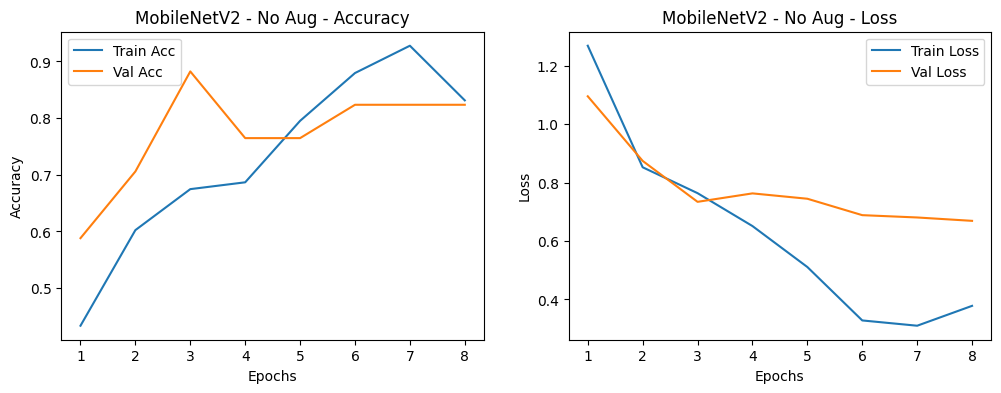

Evaluating MobileNetV2 (No Aug) on test set...
Test Accuracy (MobileNetV2 - No Aug): 0.7894737124443054


In [30]:
#no augmentation
model_mnet_no_aug = create_mobilenet_model()
history_mnet_no_aug = model_mnet_no_aug.fit(
    train_gen_no_aug,
    epochs=25,
    validation_data=val_gen,
    callbacks=[early_stop],
    verbose=1
)
plot_history(history_mnet_no_aug, "MobileNetV2 - No Aug - ")

print("Evaluating MobileNetV2 (No Aug) on test set...")
test_loss_mnet_A, test_acc_mnet_A = model_mnet_no_aug.evaluate(test_gen, verbose=0)
print("Test Accuracy (MobileNetV2 - No Aug):", test_acc_mnet_A)



Epoch 1/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.2288 - loss: 1.7313 - val_accuracy: 0.4118 - val_loss: 1.2288
Epoch 2/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 420ms/step - accuracy: 0.4768 - loss: 1.1455 - val_accuracy: 0.5882 - val_loss: 1.0198
Epoch 3/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 407ms/step - accuracy: 0.5176 - loss: 1.2079 - val_accuracy: 0.7059 - val_loss: 0.9763
Epoch 4/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 592ms/step - accuracy: 0.5818 - loss: 0.7783 - val_accuracy: 0.7647 - val_loss: 0.7925
Epoch 5/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 416ms/step - accuracy: 0.6432 - loss: 0.6914 - val_accuracy: 0.8235 - val_loss: 0.7040
Epoch 6/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 448ms/step - accuracy: 0.6774 - loss: 0.6524 - val_accuracy: 0.8824 - val_loss: 0.7242
Epoch 7/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 510ms/step - accuracy: 0.7052 - loss: 0.4951 - val_accuracy: 0.8824 - val_loss: 0.6406
Epoch 8/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 395ms/step - accuracy: 0.8398 - loss: 0.4400 - val_accuracy: 0.88

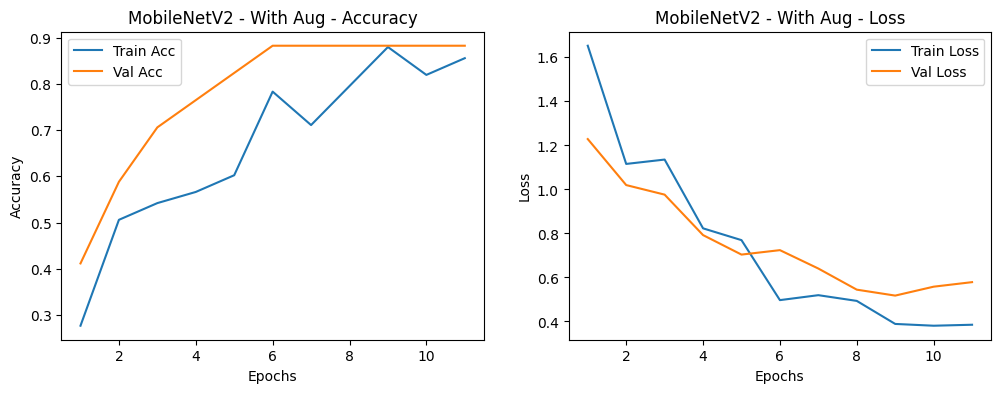

Evaluating MobileNetV2 (With Aug) on test set...
Test Accuracy (MobileNetV2 - With Aug): 0.8421052694320679


In [31]:
#with augmentation
model_mnet_aug = create_mobilenet_model()

history_mnet_aug = model_mnet_aug.fit(
    train_gen_aug,
    epochs=25,
    validation_data=val_gen,
    callbacks=[early_stop],
    verbose=1
)

plot_history(history_mnet_aug, "MobileNetV2 - With Aug - ")

print("Evaluating MobileNetV2 (With Aug) on test set...")
test_loss_mnet_B, test_acc_mnet_B = model_mnet_aug.evaluate(test_gen, verbose=0)
print("Test Accuracy (MobileNetV2 - With Aug):", test_acc_mnet_B)


fine tuning mobileNet v2

Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 17s 738ms/step - accuracy: 0.4671 - loss: 1.2690 - val_accuracy: 0.8824 - val_loss: 0.7065
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 559ms/step - accuracy: 0.5270 - loss: 0.9872 - val_accuracy: 0.8824 - val_loss: 0.6838
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 572ms/step - accuracy: 0.5104 - loss: 1.0742 - val_accuracy: 0.8824 - val_loss: 0.6697
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 489ms/step - accuracy: 0.6391 - loss: 0.7872 - val_accuracy: 0.8824 - val_loss: 0.6573
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 610ms/step - accuracy: 0.6052 - loss: 0.7919 - val_accuracy: 0.8824 - val_loss: 0.6412
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 488ms/step - accuracy: 0.6088 - loss: 0.9294 - val_accuracy: 0.8824 - val_loss: 0.6321


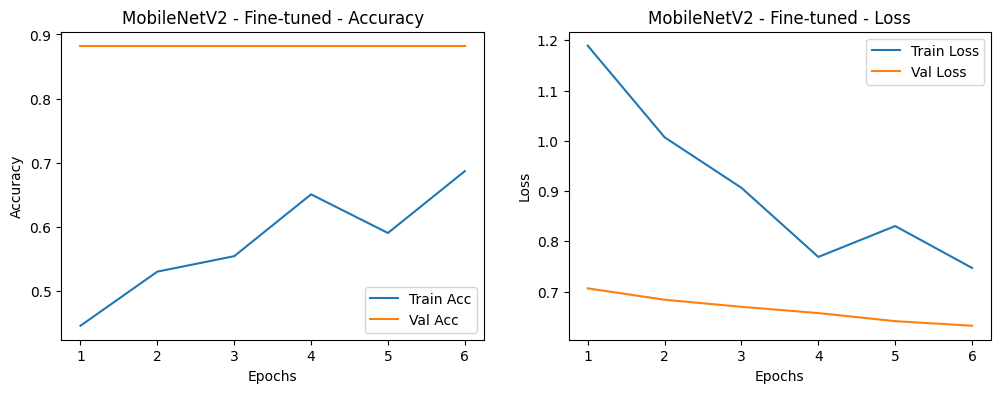

Evaluating fine-tuned MobileNetV2 on test set...
Test Accuracy (MobileNetV2 - Fine-tuned): 0.8421052694320679


In [32]:

base_model = model_mnet_aug.layers[1]   # MobileNetV2 is the 2nd layer
base_model.trainable = True

# Freeze most layers, unfreeze last 20
for layer in base_model.layers[:-20]:
    layer.trainable = False

# Re-compile with very small learning rate for fine-tuning
model_mnet_aug.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history_mnet_ft = model_mnet_aug.fit(
    train_gen_aug,
    epochs=10,
    validation_data=val_gen,
    callbacks=[early_stop],
    verbose=1
)

plot_history(history_mnet_ft, "MobileNetV2 - Fine-tuned - ")

print("Evaluating fine-tuned MobileNetV2 on test set...")
test_loss_mnet_FT, test_acc_mnet_FT = model_mnet_aug.evaluate(test_gen, verbose=0)
print("Test Accuracy (MobileNetV2 - Fine-tuned):", test_acc_mnet_FT)

Final evaluation


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 982ms/step
Confusion Matrix:
 [[6 0 0]
 [0 3 3]
 [0 0 7]]

Classification Report:

                       precision    recall  f1-score   support

Bacterial leaf blight       1.00      1.00      1.00         6
           Brown spot       1.00      0.50      0.67         6
            Leaf smut       0.70      1.00      0.82         7

             accuracy                           0.84        19
            macro avg       0.90      0.83      0.83        19
         weighted avg       0.89      0.84      0.83        19



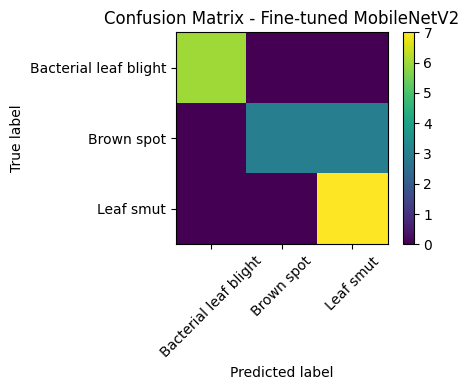

In [33]:
test_gen.reset()
y_true = test_gen.classes
y_prob = model_mnet_aug.predict(test_gen)
y_pred = np.argmax(y_prob, axis=1)
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)
class_labels = list(test_gen.class_indices.keys())
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))
plt.figure(figsize=(5,4))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix - Fine-tuned MobileNetV2")
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()


Model comparison Summary


In [34]:
print("\n\n=== MODEL COMPARISON SUMMARY (Test Accuracy) ===")
print(f"Baseline CNN (With Aug)            : {test_acc_cnn:.4f}")
print(f"MobileNetV2 (No Aug)               : {test_acc_mnet_A:.4f}")
print(f"MobileNetV2 (With Aug)             : {test_acc_mnet_B:.4f}")
print(f"MobileNetV2 (With Aug + Fine-tune) : {test_acc_mnet_FT:.4f}")




=== MODEL COMPARISON SUMMARY (Test Accuracy) ===
Baseline CNN (With Aug)            : 0.6316
MobileNetV2 (No Aug)               : 0.7895
MobileNetV2 (With Aug)             : 0.8421
MobileNetV2 (With Aug + Fine-tune) : 0.8421
